## 0. Import Libraries

In [240]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

In [20]:
variable = '__xarray_dataarray_variable__'

### 1.1 ERA5

In [3]:
# era5
ivt_era5_urban = xr.open_dataset(r'data/ivt_era5_postprocessed_urban.nc')
ivt_era5_nourban = xr.open_dataset(r'data/ivt_era5_postprocessed_nourban.nc')

### 1.2 GFS

In [4]:
# gfs
ivt_gfs_urban = xr.open_dataset(r'data/ivt_gfs_postprocessed_urban.nc')
ivt_gfs_nourban = xr.open_dataset(r'data/ivt_gfs_postprocessed_nourban.nc')

## 2. Vectorize Tiff Data

In [253]:
proj_dt = xr.open_dataset(r'data/era5_LIN_nourban_ACLHF_wrfout_d03_2017-07-17.nc')
proj_dt = proj_dt.rio.write_crs(proj_dt['ACLHF'].attrs['pyproj_srs'])

In [254]:
gg = rioxarray.open_rasterio('data/lu_index/urban_luse_border_raster.tiff').squeeze('band', drop=True)

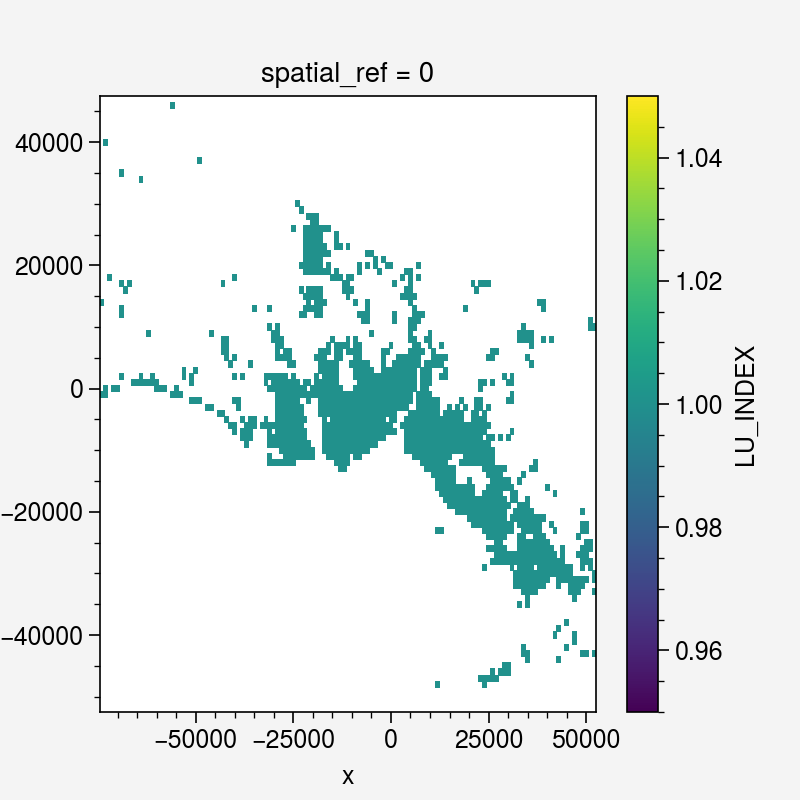

In [255]:
gg.plot()

In [256]:
gg = gg.rio.write_crs(proj_dt.rio.crs)
gdf = xr_vectorize(gg,
                   crs=gg.rio.crs,
                   mask=gg.values==1)

<AxesSubplot:>

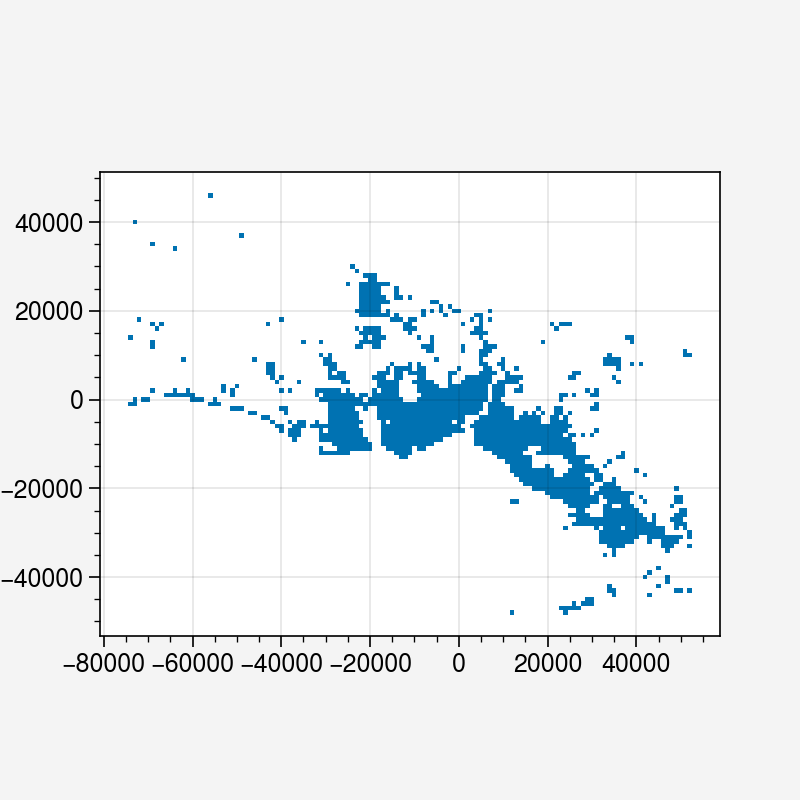

In [257]:
gdf.plot()

In [258]:
def clip_to_city(data, shapefile, crs_data, x_dims, y_dims):
    
    data= data.rio.set_spatial_dims(x_dim=x_dims, y_dim=y_dims)

    data = data.rio.write_crs(crs_data)
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [259]:
x_dims = 'west_east'
y_dims = 'south_north'

## 3. Calculate IVT for urban borders

In [24]:
ivt_era5_urban_clip = clip_to_city(ivt_era5_urban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_era5_nourban_clip = clip_to_city(ivt_era5_nourban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_gfs_urban_clip = clip_to_city(ivt_gfs_urban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_gfs_nourban_clip = clip_to_city(ivt_gfs_nourban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

In [177]:
# era5 grid-based diff urban borders
ivt_era5_urban_minus_nourban = ivt_era5_urban_clip[variable] - ivt_era5_nourban_clip[variable] 

# gfs grid-based diff urban borders
ivt_gfs_urban_minus_nourban = ivt_gfs_urban_clip[variable] - ivt_gfs_nourban_clip[variable]

In [179]:
required_cols = ['time', 'XLONG', 'XLAT', variable]

In [181]:
pd_ivt_era5_urban_minus_nourban = ivt_era5_urban_minus_nourban.to_dataframe().dropna().reset_index()[required_cols]
pd_ivt_gfs_urban_minus_nourban = ivt_gfs_urban_minus_nourban.to_dataframe().dropna().reset_index()[required_cols]

In [182]:
pd_ivt_era5_urban_minus_nourban

,time,XLONG,XLAT,__xarray_dataarray_variable__
0,2017-07-18 07:00:00,29.115234,40.640182,-155.885193
1,2017-07-18 07:00:00,29.127106,40.640179,-154.232178
2,2017-07-18 07:00:00,29.257477,40.639915,-300.562317
3,2017-07-18 07:00:00,29.269318,40.639896,-278.543396
4,2017-07-18 07:00:00,29.115265,40.649178,-110.197815
...,...,...,...,...
13069,2017-07-18 12:00:00,28.097137,41.437489,51.276978
13070,2017-07-18 12:00:00,28.288635,41.483749,-15.788818
13071,2017-07-18 12:00:00,28.300659,41.483818,-9.315918
13072,2017-07-18 12:00:00,28.288544,41.492744,-62.104492


## 4. Visualization

<AxesSubplot:xlabel='time', ylabel='__xarray_dataarray_variable__'>

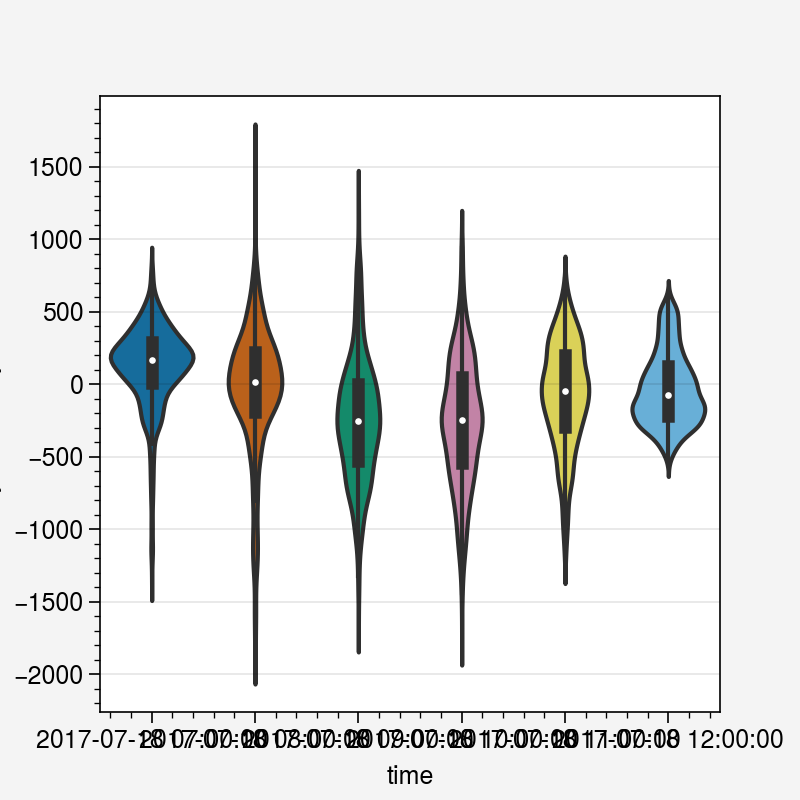

In [260]:
sns.violinplot(data=pd_ivt_era5_urban_minus_nourban,
             x='time',
             y=variable,
             showfliers = False)

<AxesSubplot:xlabel='time', ylabel='__xarray_dataarray_variable__'>

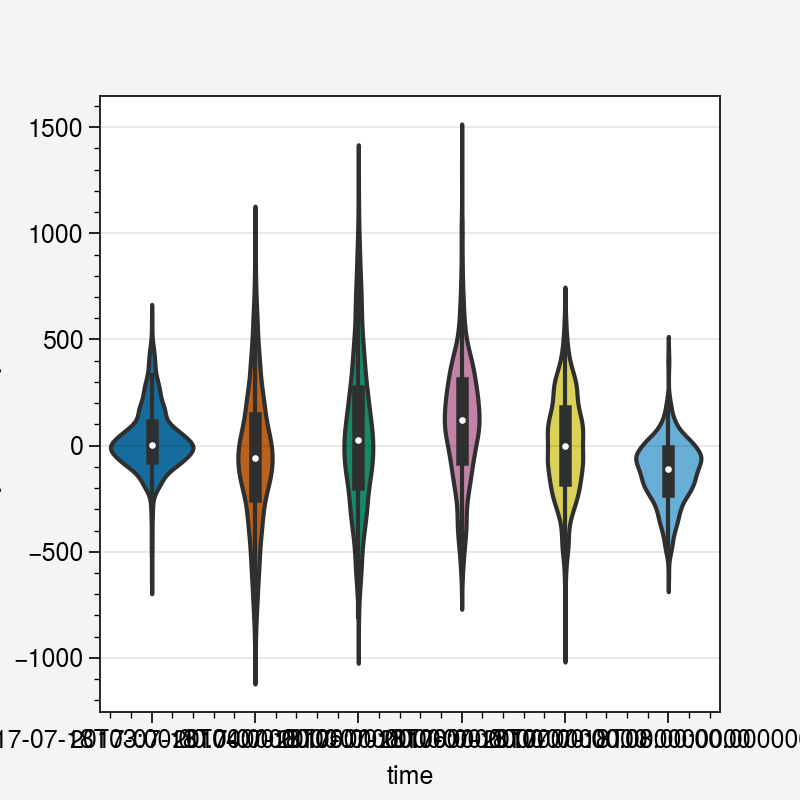

In [261]:
sns.violinplot(data=pd_ivt_gfs_urban_minus_nourban,
             x='time',
             y=variable,
             showfliers = False)

## 5. Supporting Calculations

In [262]:
pd_ivt_era5_urban_minus_nourban['time'] = pd_ivt_era5_urban_minus_nourban['time'].astype('str')

In [266]:
i = 0 # time indicator

t = pd_ivt_era5_urban_minus_nourban['time'].unique()[i]
d = pd_ivt_gfs_urban_minus_nourban['time'].unique()[i]

print(fr"era5 median IVT diff. for {t}: ", pd_ivt_era5_urban_minus_nourban.query(fr'time=="{t}"')[variable].median())
print(fr"gfs median IVT diff. for {t}: ", pd_ivt_gfs_urban_minus_nourban.query(fr'time=="{d}"')[variable].median())

era5 median IVT diff. for 2017-07-18 07:00:00:  166.1591796875
gfs median IVT diff. for 2017-07-18 07:00:00:  5.2904052734375
